In [36]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score
from itertools import product
from sklearn.model_selection import StratifiedKFold
import optuna
import plotly.express as px
from collections import Counter
import umap.umap_ as umap
import matplotlib
from sklearn.manifold import Isomap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from os.path import join

In [8]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [9]:
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})

In [10]:
def fill_repeater_from_source(row, data):
    if row['Source'] == 'FRB20220912A':
        return 1
    else:
        return row['Repeater']

In [11]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)
frb_data['Repeater'] = frb_data.apply(fill_repeater_from_source, axis=1, data=frb_data)

frb_data['Repeater'].isna().sum()

np.int64(0)

In [12]:
labels = frb_data['Repeater']

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if isinstance(value, str):
        value = value.strip()
        if not value:
            return np.nan
        try:
            # Remove special characters and split if necessary
            for char in ['/', '+', '<', '>', '~']:
                value = value.replace(char, '')
            if '-' in value:
                value = value.split('-')[0]
            return float(value)
        except ValueError:
            return np.nan
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan
    
error_features = [
    'DM_SNR', 'DM_alig', 'Flux_density', 'Fluence', 'Energy',
    'Polar_l', 'Polar_c', 'RM_syn', 'RM_QUfit', 'Scatt_t', 
    #'Scin_f'
]
base_features = [
    'Observing_band', 
    # 'GL', 'GB', 
    'SNR', 'Freq_high',
    'Freq_low', 'Freq_peak', 
    'Width'
    # 'Repeater',
    #'MJD'
]

for feature in base_features + error_features:
    frb_data[feature] = frb_data[feature].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_err'] = frb_data[f'{feature}_err'].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_upper'] = frb_data[feature] + frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[feature] - frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[f'{feature}_lower'].clip(lower=0)

features = (
    base_features +
    error_features +
    [f'{feature}_upper' for feature in error_features] +
    [f'{feature}_lower' for feature in error_features]
)

In [13]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

# Retain the original indices
indices = frb_data_clean.index

# Split the data and retain indices
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
class SupervisedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(SupervisedVAE, self).__init__()

        self.activation = activation

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),  # Additional dense layer
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),  # Additional dense layer
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )

        # Classification head for binary classification - tune hyperparameters
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),  # Added extra linear layer
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 4, 1),
        )


    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        class_prob = self.classifier(mu)
        return recon_x, mu, logvar, class_prob


In [15]:
def loss_function(recon_x, x, mu, logvar, class_prob, labels, beta, gamma, class_weight, classification_multiplier):
    reconstruction_loss_fn = nn.MSELoss(reduction='sum')
    pos_weight = torch.tensor([class_weight], dtype=torch.float32, device=device)
    classification_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # check this loss function
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = classification_multiplier * classification_loss_fn(class_prob, labels.unsqueeze(1).float())
    total_loss = recon_loss + beta * kl_loss + gamma * class_loss
    return total_loss, recon_loss, kl_loss, class_loss

In [16]:
input_dim = val_tensor.shape[1]
hidden_dim = 256
latent_dim = 10
stop_patience = 8
num_epochs = 150

In [17]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='weighted')

    
    false_positives = np.sum((all_labels == 0) & (all_preds == 1))

    return accuracy, class_report, conf_matrix, recall, false_positives  # Return F1 score as well

def get_activation_function(name):
    if name == 'ReLU':
        return nn.ReLU()
    elif name == 'LeakyReLU':
        return nn.LeakyReLU(0.1)
    elif name == 'ELU':
        return nn.ELU()
    elif name == 'SELU':
        return nn.SELU()
    elif name == 'GELU':
        return nn.GELU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
import sklearn.metrics

def evaluate_classifier_full(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = sklearn.metrics.f1_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return f1, class_report, conf_matrix, all_preds, all_labels

original_data = pd.read_csv('frb-data.csv')
original_data['Repeater'] = original_data['Repeater'].map({'Yes': 1, 'No': 0})
print(original_data['Repeater'].isna().sum())

print(f"Number of NaN values in 'Repeater' column before processing: {original_data['Repeater'].isna().sum()}")
# Apply the function row-wise
original_data['Repeater'] = original_data.apply(fill_repeater_from_source, axis=1, data=original_data)

print(f"Number of NaN values in 'Repeater' column after processing: {original_data['Repeater'].isna().sum()}")

443
Number of NaN values in 'Repeater' column before processing: 443
Number of NaN values in 'Repeater' column after processing: 0


In [19]:
best_params = {'hidden_dim': 1082, 'latent_dim': 18, 'beta': 1.149574612306723, 'gamma': 1.9210647260496314, 'dropout_rate': 0.13093239424733344, 'lr': 0.0011823749066137313, 'scheduler_patience': 7, 'class_weight': 0.35488674730648145, 'activation': 'ReLU', 'classification_multiplier': 7817.124805902009}

beta = best_params["beta"]
gamma = best_params["gamma"]
lr = best_params["lr"]
scheduler_patience = best_params["scheduler_patience"]
num_epochs = 150

In [20]:
garcia_list = '''
FRB20180907E
FRB20180920B
FRB20180928A
FRB20181017B
FRB20181022E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181214A
FRB20181220A
FRB20181226E
FRB20181229B
FRB20190112A
FRB20190128C
FRB20190206B
FRB20190206A
FRB20190218B
FRB20190223A
FRB20190308C
FRB20190308C
FRB20190323D
FRB20190329A
FRB20190410A
FRB20190412B
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190527A
FRB20190527A
FRB20190601C
FRB20190601C
FRB20190617B
FRB20180910A
FRB20190210C
FRB20200726D
'''.split()

luo_list = '''
FRB20181229B
FRB20190423B
FRB20190410A
FRB20181017B
FRB20181128C
FRB20190422A
FRB20190409B
FRB20190329A
FRB20190423B
FRB20190206A
FRB20190128C
FRB20190106A
FRB20190129A
FRB20181030E
FRB20190527A
FRB20190218B
FRB20190609A
FRB20190412B
FRB20190125B
FRB20181231B
FRB20181221A
FRB20190112A
FRB20190125A
FRB20181218C
FRB20190429B
FRB20190109B
FRB20190206B
'''.split()

zhu_ge_list = '''
FRB20180911A
FRB20180915B
FRB20180920B
FRB20180923A
FRB20180923C
FRB20180928A
FRB20181013E
FRB20181017B
FRB20181030E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181130A
FRB20181214A
FRB20181220A
FRB20181221A
FRB20181226E
FRB20181229B
FRB20181231B
FRB20190106B
FRB20190109B
FRB20190110C
FRB20190111A
FRB20190112A
FRB20190129A
FRB20190204A
FRB20190206A
FRB20190218B
FRB20190220A
FRB20190221A
FRB20190222B
FRB20190223A
FRB20190228A
FRB20190308C
FRB20190308C
FRB20190308B
FRB20190308B
FRB20190323D
FRB20190329A
FRB20190403E
FRB20190409B
FRB20190410A
FRB20190412B
FRB20190418A
FRB20190419A
FRB20190422A
FRB20190422A
FRB20190423A
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190517C
FRB20190527A
FRB20190527A
FRB20190531C
FRB20190601B
FRB20190601C
FRB20190601C
FRB20190609A
FRB20190617A
FRB20190617B
FRB20190618A
FRB20190625A
'''.split()

In [21]:
all_false_positives = []
all_false_negatives = []
all_true_positives = []
all_true_negatives = []

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

full_data_tensor = torch.tensor(frb_data_scaled, dtype=torch.float32)
full_labels_tensor = torch.tensor(labels.values, dtype=torch.long)

for fold, (train_index, val_index) in enumerate(skf.split(frb_data_scaled, labels)):
    
    val_data = frb_data_scaled[val_index]
    val_labels = labels.iloc[val_index]

    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

    val_dataset = TensorDataset(val_tensor, val_labels_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model structure
    best_model = SupervisedVAE(
        input_dim,
        best_params["hidden_dim"],
        best_params["latent_dim"],
        best_params["dropout_rate"],
        get_activation_function(best_params["activation"])
    ).to(device)

    # Load the pre-trained weights
    best_model.load_state_dict(torch.load("optimized341.pth", map_location=device))
    best_model.eval()

    # Direct evaluation
    val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader, device)

    misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
    misclassified_indices = val_index[misclassified_non_repeaters]
    misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()

    false_positives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 1)], "Source"]
    false_negatives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 0)], "Source"]
    true_positives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 1)], "Source"]
    true_negatives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 0)], "Source"]

    for source in misclassified_sources:
        if source in garcia_list or source in luo_list or source in zhu_ge_list:
            print(f"False positive in fold {fold + 1}: {source}")

    all_false_negatives.extend(false_negatives_fold)
    all_true_positives.extend(true_positives_fold)
    all_true_negatives.extend(true_negatives_fold)
    all_false_positives.extend(false_positives_fold)

# After all folds
all_false_positives = pd.Series(all_false_positives)
all_false_negatives = pd.Series(all_false_negatives)
all_true_positives = pd.Series(all_true_positives)
all_true_negatives = pd.Series(all_true_negatives)

print("")

print("\n=== Summary ===")
print(f"Total False Positives: {all_false_positives.size}")
print(f"Total False Negatives: {all_false_negatives.size}")
print(f"Total True Positives: {all_true_positives.size}")
print(f"Total True Negatives: {all_true_negatives.size}")

conf_mat_dups = np.zeros((2, 2))
conf_mat_dups[0, 0] = all_true_negatives.size
conf_mat_dups[0, 1] = all_false_positives.size
conf_mat_dups[1, 0] = all_false_negatives.size
conf_mat_dups[1, 1] = all_true_positives.size

print(conf_mat_dups)

# Accuracy:
accuracy = (all_true_positives.size + all_true_negatives.size) / (all_false_positives.size + all_false_negatives.size + all_true_positives.size + all_true_negatives.size)
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall (Sensitivity): {all_true_positives.size / (all_true_positives.size + all_false_negatives.size):.4f}")

False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 5: FRB20190112A


=== Summary ===
Total False Positives: 29
Total False Negatives: 21
Total True Positives: 7895
Total True Negatives: 719
[[ 719.   29.]
 [  21. 7895.]]
Accuracy: 0.9942
Recall (Sensitivity): 0.9973


In [22]:
best_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

best_model.load_state_dict(torch.load("optimized341.pth", map_location=device))

result = evaluate_classifier_full(best_model, val_loader, device)

result[2]

array([[ 145,    4],
       [   7, 1576]])

In [43]:
def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latent_representations.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(latent_representations), np.concatenate(all_labels)


def visualize_latent_space_pca(latent_representations, labels, model, device, title='PCA of Latent Space Representations', file_path='figs'):
    # Perform PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    # Plot the 2D latent space
    plt.figure(figsize=(16, 9))
    #scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='plasma', s=10)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')), dpi=500, format='svg')
    plt.show()




def cluster_and_visualize(latent_representations, labels, title='Clusters in PCA-Transformed Latent Space', file_path='figs'):
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    n_clusters = len(np.unique(labels))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_2d)
    
    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=cluster_labels, palette='viridis', s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend(title="Cluster")
    plt.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')), dpi=500, format='svg')
    plt.show()
    

    silhouette = silhouette_score(latent_2d, cluster_labels)
    print(f"Silhouette Score: {silhouette}")

    ari = adjusted_rand_score(labels, cluster_labels)
    print(f"Adjusted Rand Index (ARI): {ari}")

def visualize_latent_space_tsne(latent_representations, labels, title='t-SNE of Latent Space Representations', palette='tab20', file_path='figs'):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_representations)

    
    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette=palette, s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')), dpi=500, format='svg')

    plt.show()


def visualize_latent_space_umap(latent_representations, labels, title="UMAP of Latent Space Representations", palette='tab20', file_path='figs'):
    reducer = umap.UMAP(n_components=2, random_state=42)
    latent_2d = reducer.fit_transform(latent_representations)
        
    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette=palette, s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    # save as svg
    plt.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')), dpi=500, format='svg')
    plt.show()


def visualize_latent_space_isomap(latent_representations, labels, title="Isomap of Latent Space Representations", palette='tab20', file_path='figs'):
    isomap = Isomap(n_components=2)
    latent_2d = isomap.fit_transform(latent_representations)
    
    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette=palette, s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('Isomap Dimension 1')
    plt.ylabel('Isomap Dimension 2')
    plt.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')), dpi=500, format='svg')
    plt.show()

In [44]:
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

source_data_val = list(original_data.loc[val_indices, "Source"])
source_data_val

source_data_train = list(original_data.loc[train_indices, "Source"])


def get_source_data_val_freq(n=20):
    global source_data_val
    label_counts = Counter(source_data_val)
    top_labels = [label for label, _ in label_counts.most_common(n)]
    source_data_val_freq = [label if label in top_labels else 'Other' for label in source_data_val]

    return source_data_val_freq



# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [45]:
train_latent, train_labels_np = get_latent_representations(best_model, train_loader, device)
val_latent, val_labels_np = get_latent_representations(best_model, val_loader, device)


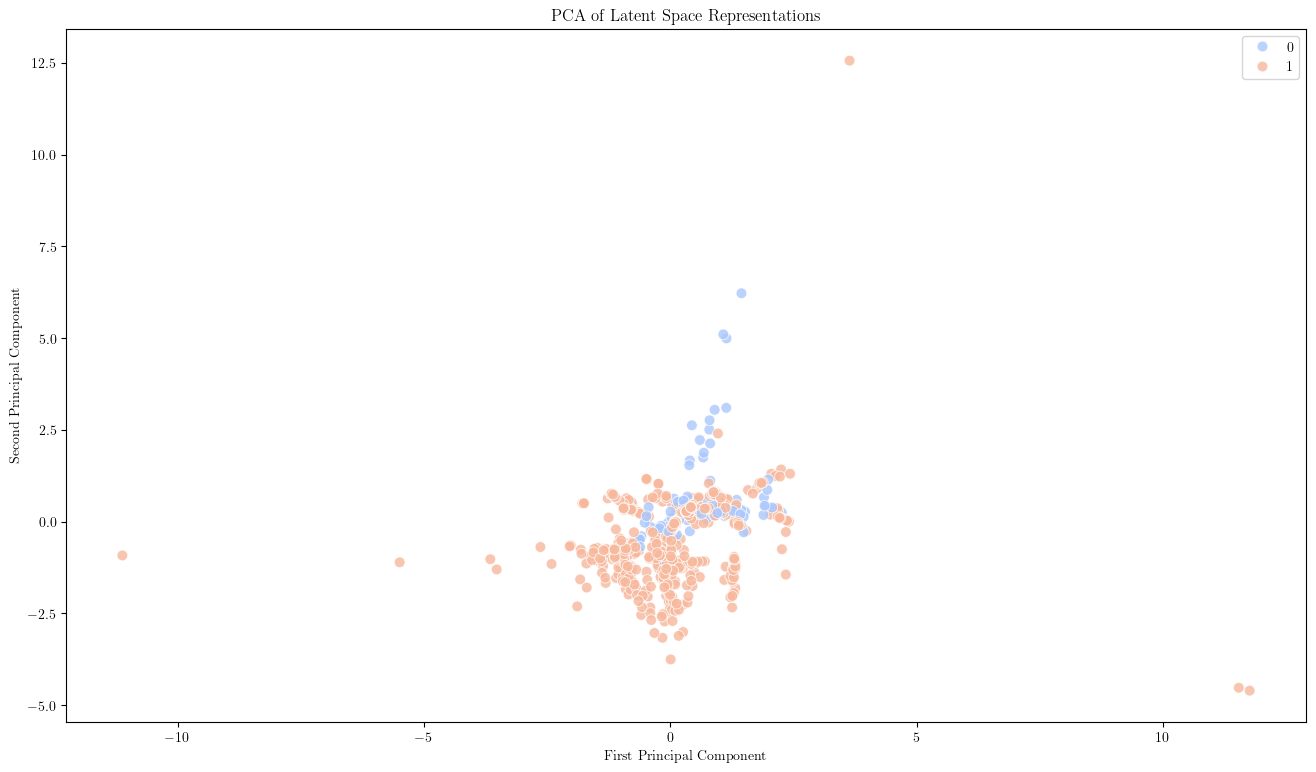

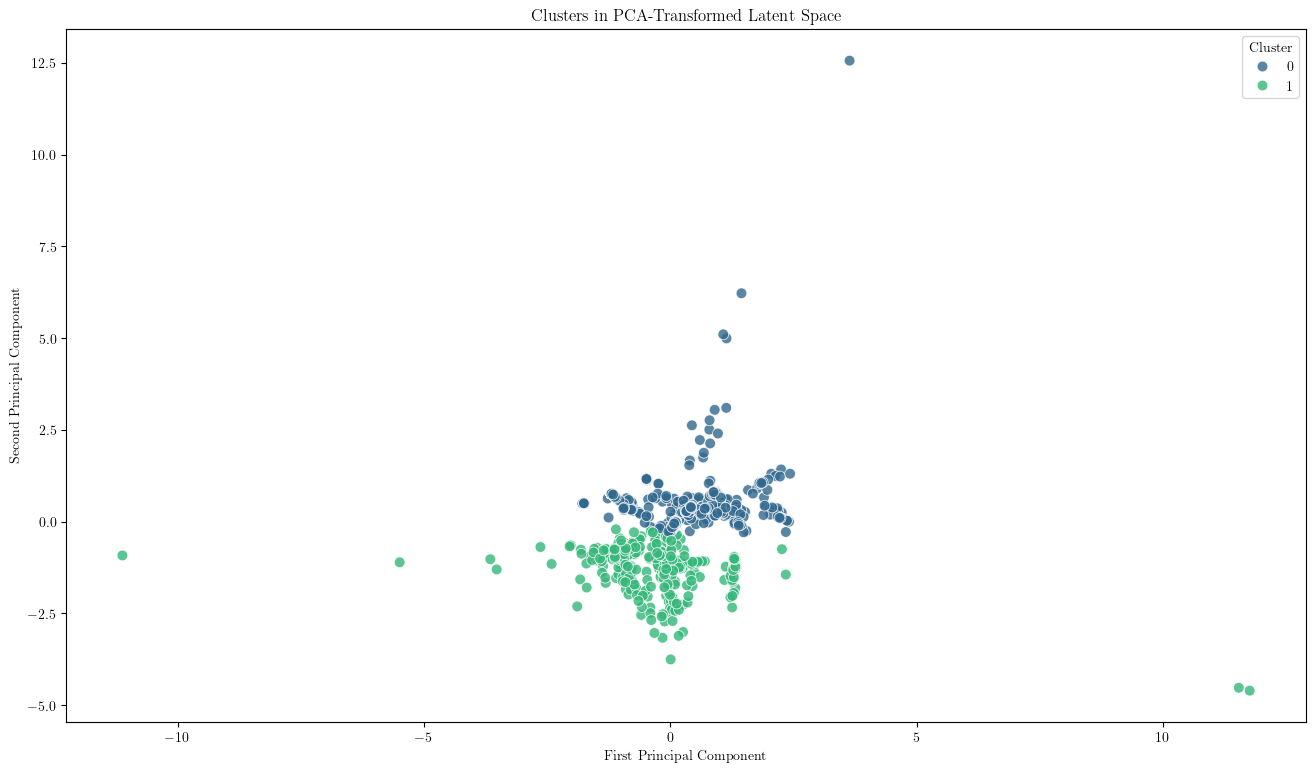

Silhouette Score: 0.4328971803188324
Adjusted Rand Index (ARI): -0.05271175344088743


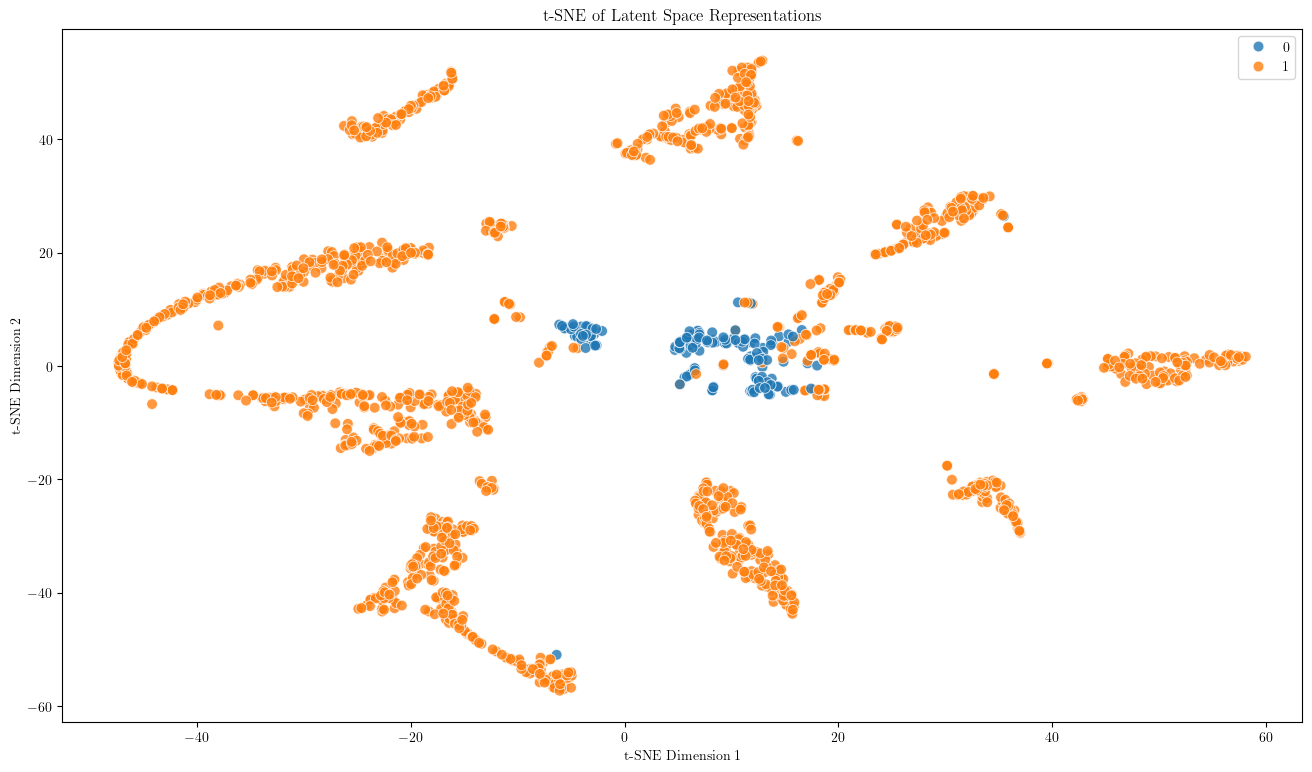

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


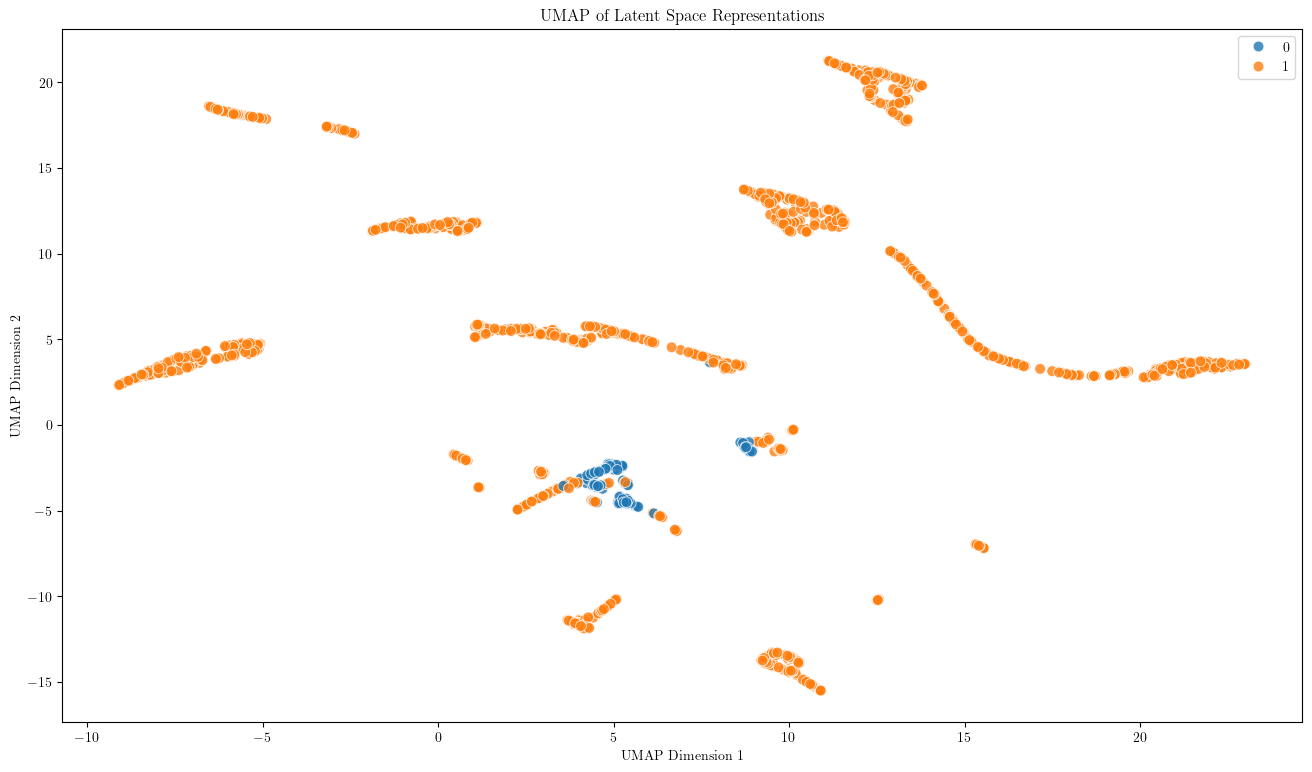

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 6 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is e

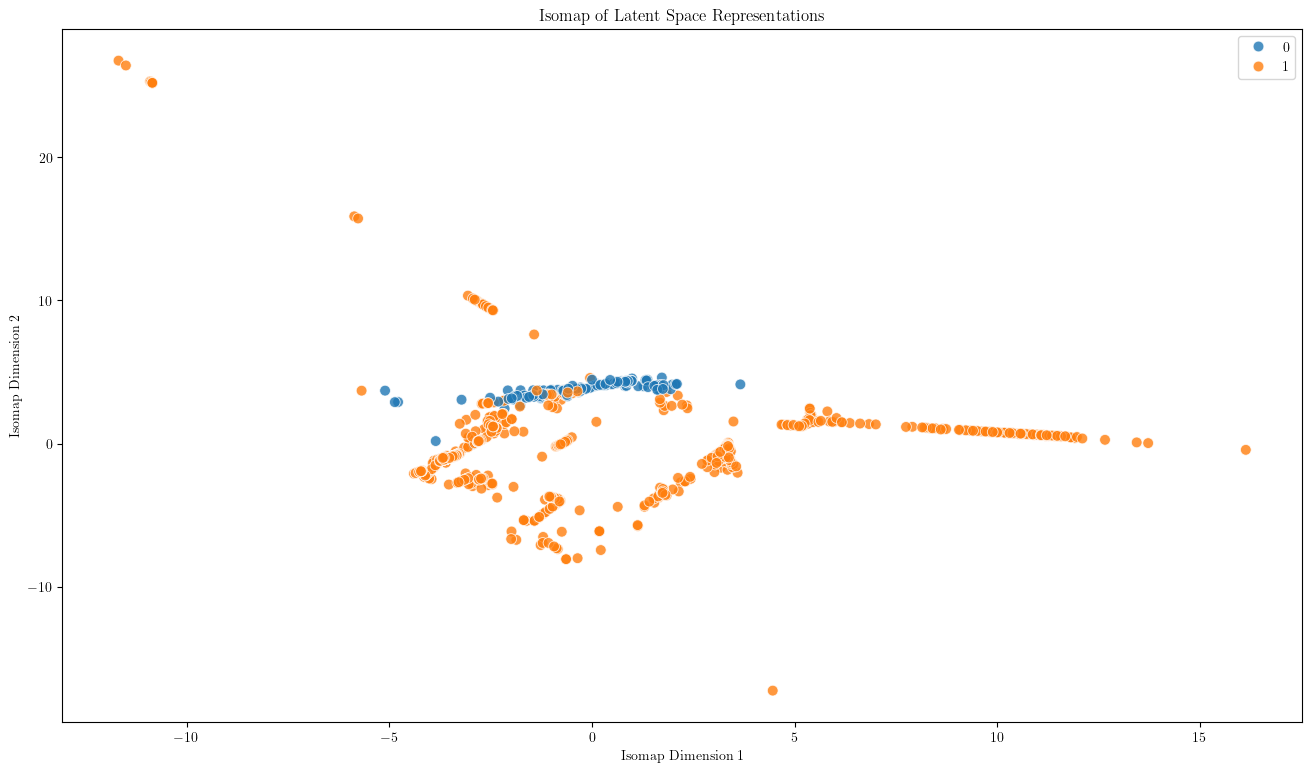

In [46]:
visualize_latent_space_pca(val_latent, val_labels_np, None, None, file_path='figs/full_dataset')
cluster_and_visualize(val_latent, val_labels_np, title='Clusters in PCA-Transformed Latent Space', file_path='figs/full_dataset')
visualize_latent_space_tsne(val_latent, val_labels_np, palette='tab10', file_path='figs/full_dataset')
visualize_latent_space_umap(val_latent, val_labels_np, palette='tab10', file_path='figs/full_dataset')
visualize_latent_space_isomap(val_latent, val_labels_np, palette='tab10', file_path='figs/full_dataset')

In [27]:
print(val_latent.shape)
print(val_labels_np.shape)
print(len(get_source_data_val_freq(20)))

(1733, 18)
(1733,)
1733


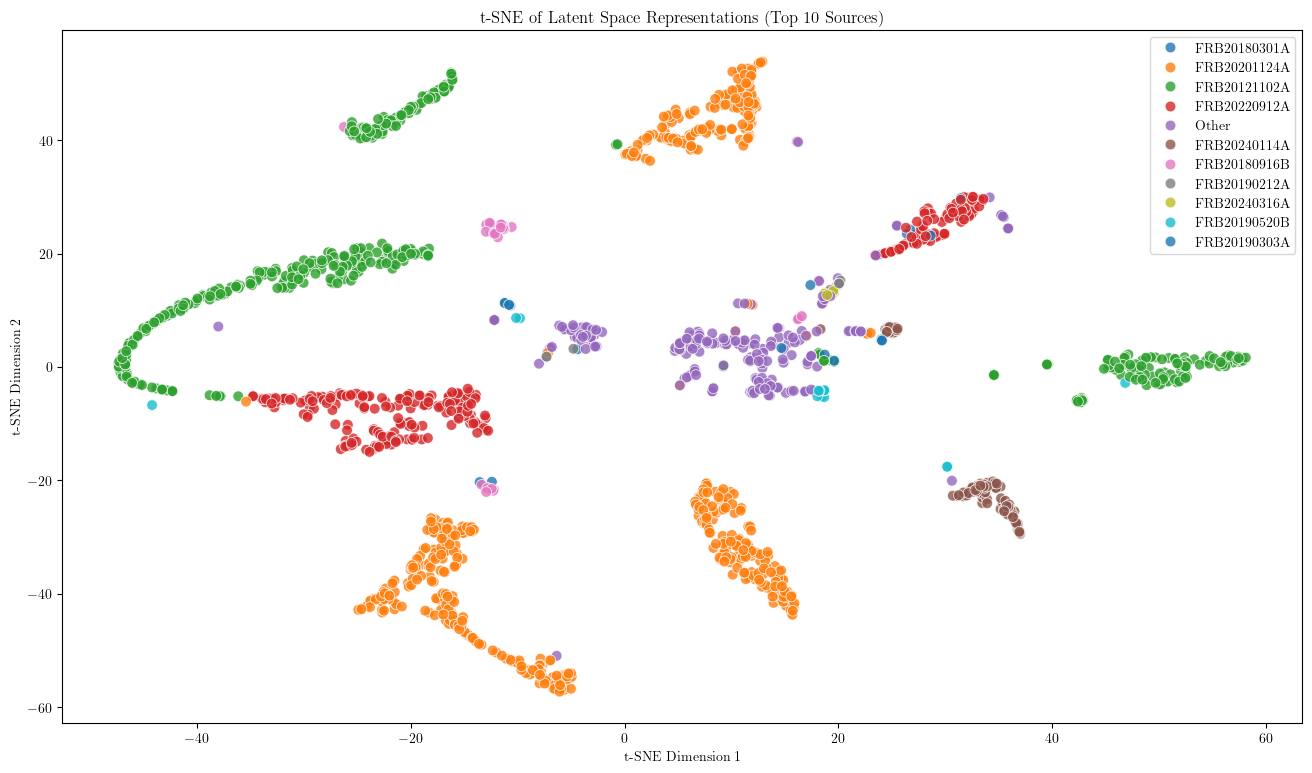

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


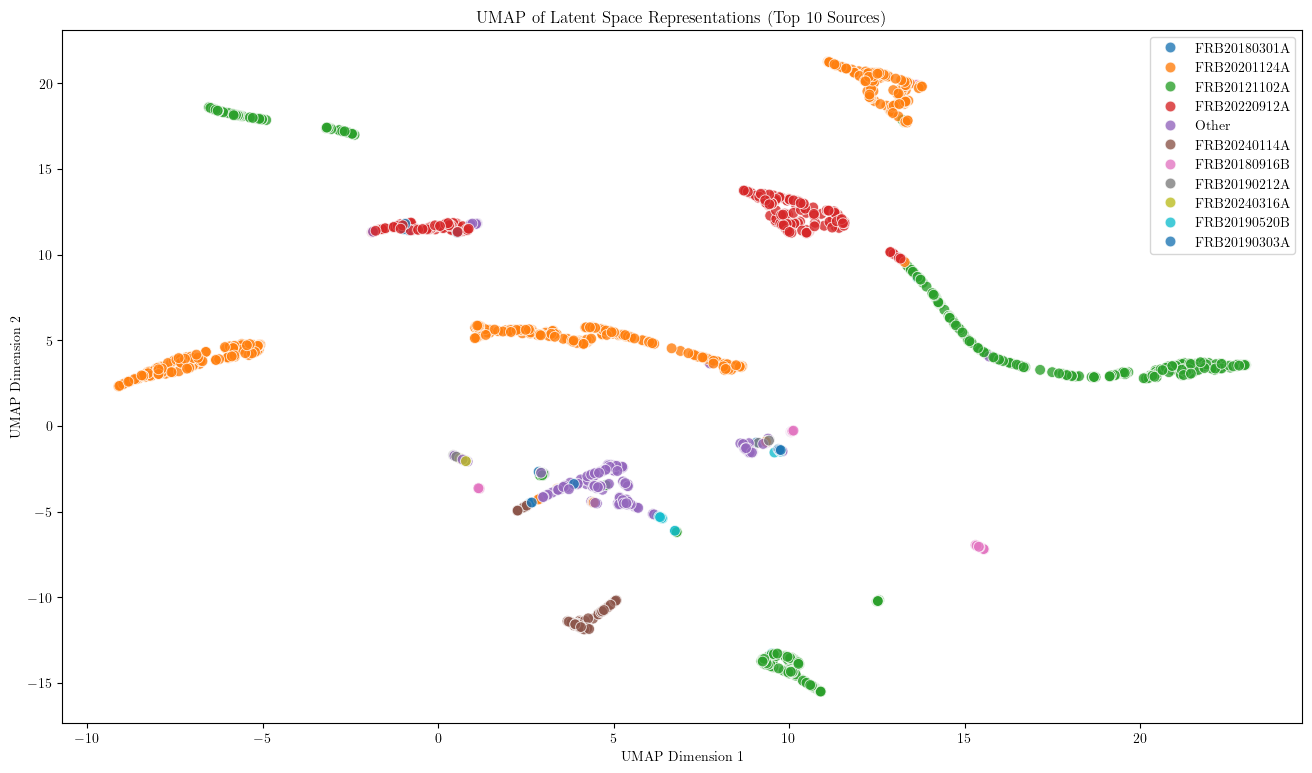

In [47]:
visualize_latent_space_tsne(val_latent, get_source_data_val_freq(10)[:], title='t-SNE of Latent Space Representations (Top 10 Sources)', palette='tab10', file_path='figs/full_dataset')
visualize_latent_space_umap(val_latent, get_source_data_val_freq(10), title='UMAP of Latent Space Representations (Top 10 Sources)', palette='tab10', file_path='figs/full_dataset')

In [ ]:
def visualize_latent_space_tsne_interactive(latent_representations, labels):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_representations)

    tsne_df = pd.DataFrame({
        'TSNE-1': latent_2d[:, 0],
        'TSNE-2': latent_2d[:, 1],
        'Label': labels
    })

    fig = px.scatter(
        tsne_df, 
        x='TSNE-1', 
        y='TSNE-2', 
        color='Label', 
        hover_data=['Label'], 
        title='Interactive t-SNE of Latent Space Representations',
        width=800,
        height=800
    )

    fig.show()

visualize_latent_space_tsne_interactive(val_latent, get_source_data_val_freq(10))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Step 1: Identify the 5 most frequent repeaters
repeater_counts = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts()
top_5_repeaters = repeater_counts.head(5).index.tolist()

# Step 2: Filter the dataset to exclude these repeaters
filtered_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index
filtered_data_clean = frb_data_clean.loc[filtered_indices]
filtered_labels = labels.loc[filtered_indices]

# Step 3: Standardize the filtered dataset
scaler = StandardScaler()
filtered_data_scaled = scaler.fit_transform(filtered_data_clean)

# Step 4: Split the filtered dataset into train and validation sets
train_data_filtered, val_data_filtered, train_labels_filtered, val_labels_filtered = train_test_split(
    filtered_data_scaled, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
)

# Step 5: Convert to PyTorch tensors
train_tensor_filtered = torch.tensor(train_data_filtered, dtype=torch.float32)
val_tensor_filtered = torch.tensor(val_data_filtered, dtype=torch.float32)
train_labels_tensor_filtered = torch.tensor(train_labels_filtered.values, dtype=torch.long)
val_labels_tensor_filtered = torch.tensor(val_labels_filtered.values, dtype=torch.long)

# Step 6: Create datasets and dataloaders
batch_size = 64
train_dataset_filtered = TensorDataset(train_tensor_filtered, train_labels_tensor_filtered)
val_dataset_filtered = TensorDataset(val_tensor_filtered, val_labels_tensor_filtered)

train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=batch_size, shuffle=True)
val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=batch_size, shuffle=False)


In [ ]:


# Step 7: Train the model with the filtered dataset
filtered_model_1 = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

# set modle weights
filtered_model_1.load_state_dict(torch.load("model_weights_filtered_repeaters.pth", map_location=device))

# Evaluate the model after training
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(filtered_model_1, val_loader_filtered, device)

print("\n=== Final Evaluation ===")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)



=== Final Evaluation ===
Validation Accuracy: 0.8696
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.86      0.96      0.91       150
    Repeater       0.94      0.81      0.87       124

    accuracy                           0.89       274
   macro avg       0.90      0.88      0.89       274
weighted avg       0.90      0.89      0.89       274

Confusion Matrix:
 [[144   6]
 [ 24 100]]


/tmp/ipykernel_1895578/2466387788.py:11: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.




=== PCA Visualization ===


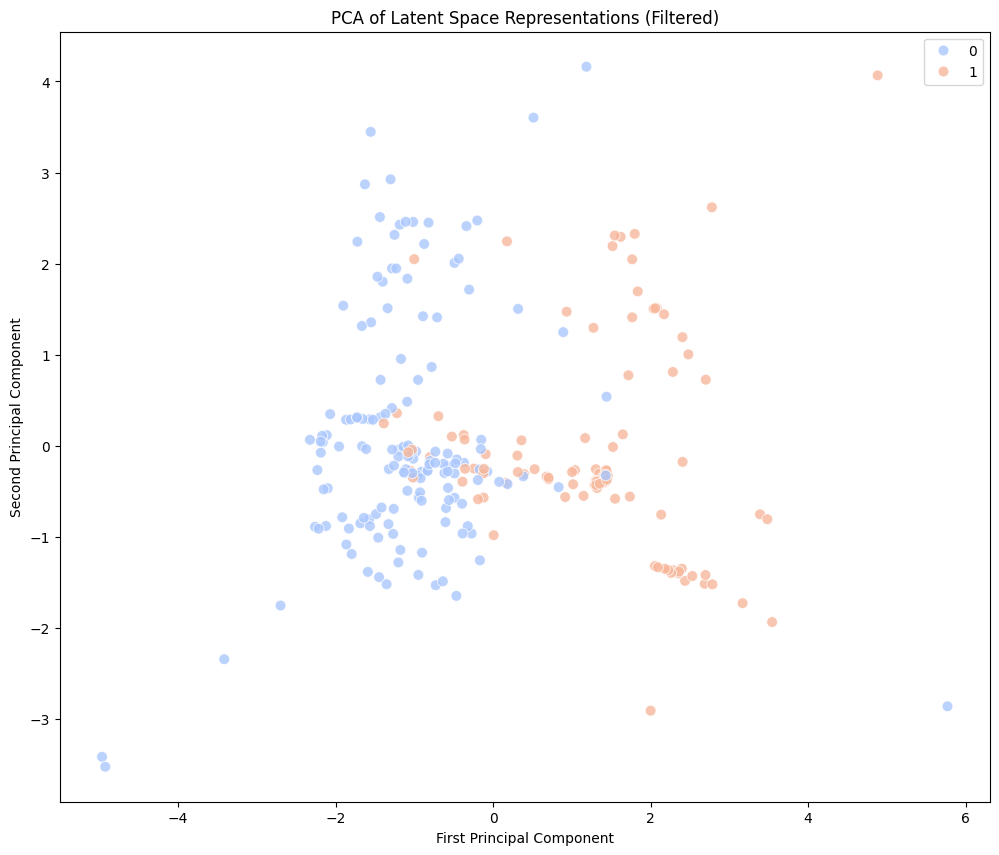


=== Clustering Analysis in Latent Space ===


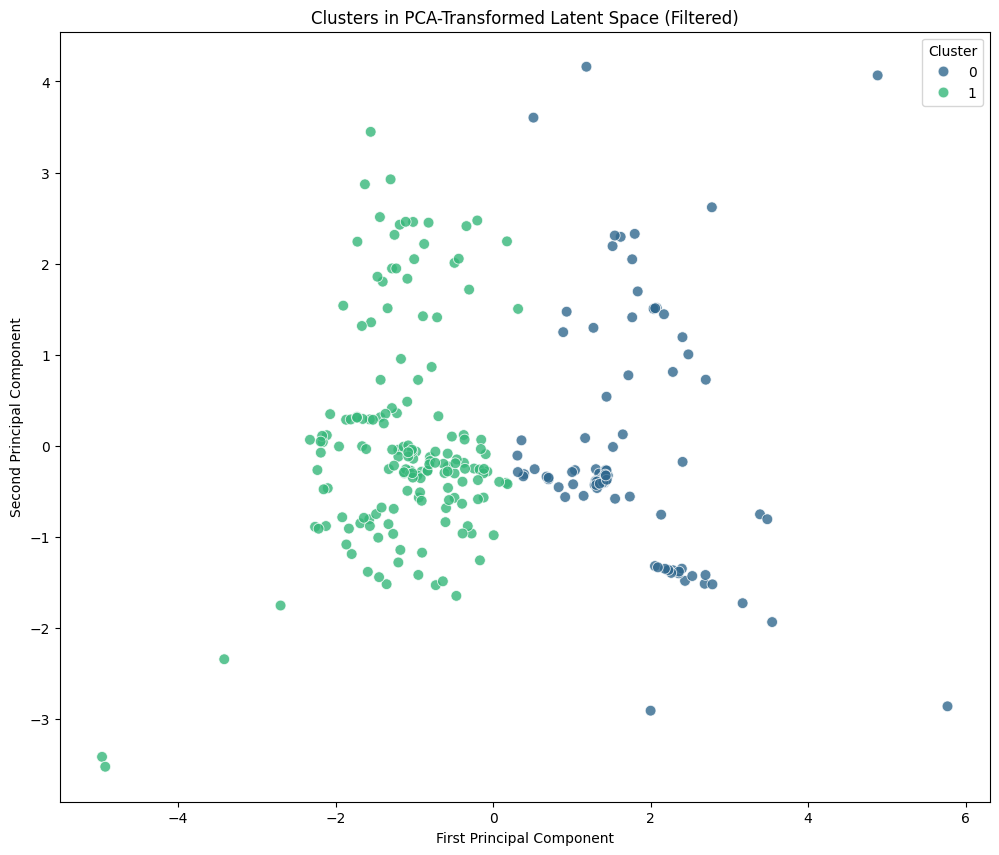

Silhouette Score: 0.48802658915519714
Adjusted Rand Index (ARI): 0.5970936997427123

=== t-SNE Visualization ===


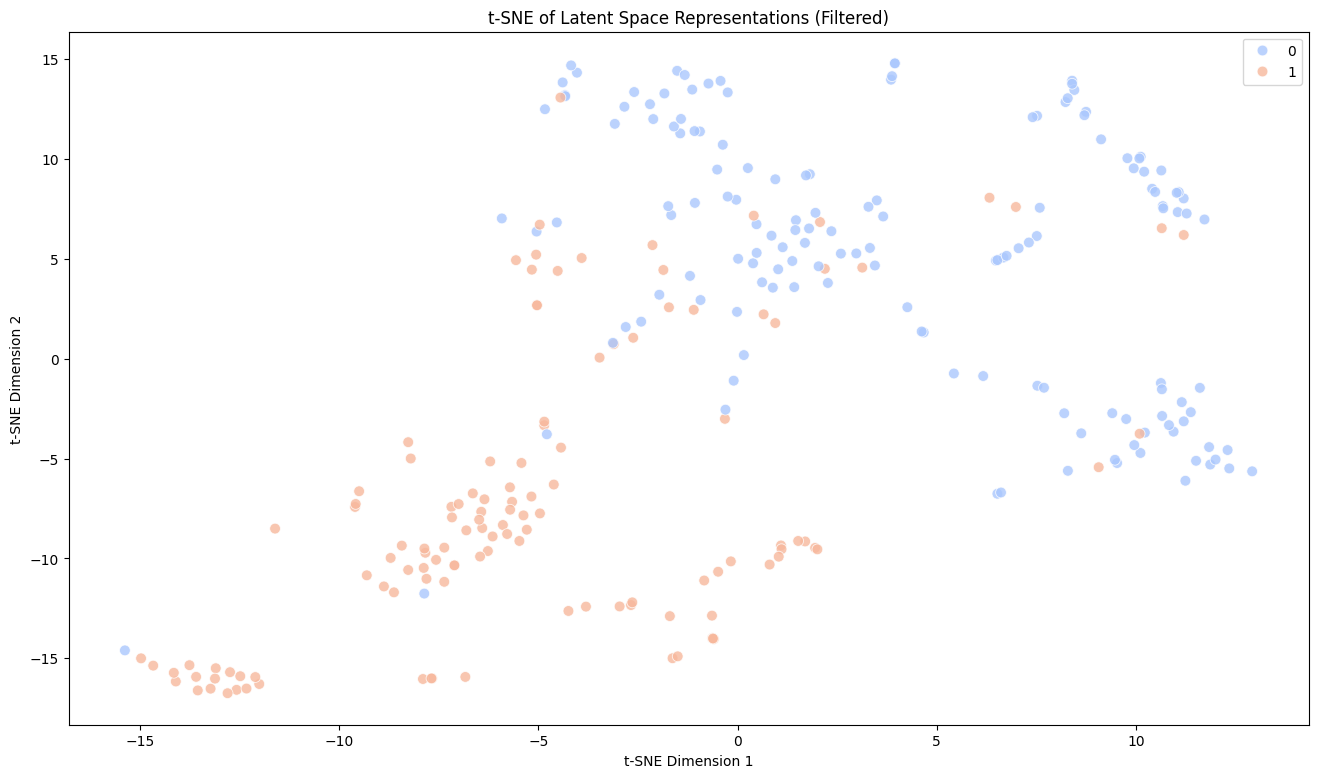


=== UMAP Visualization ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



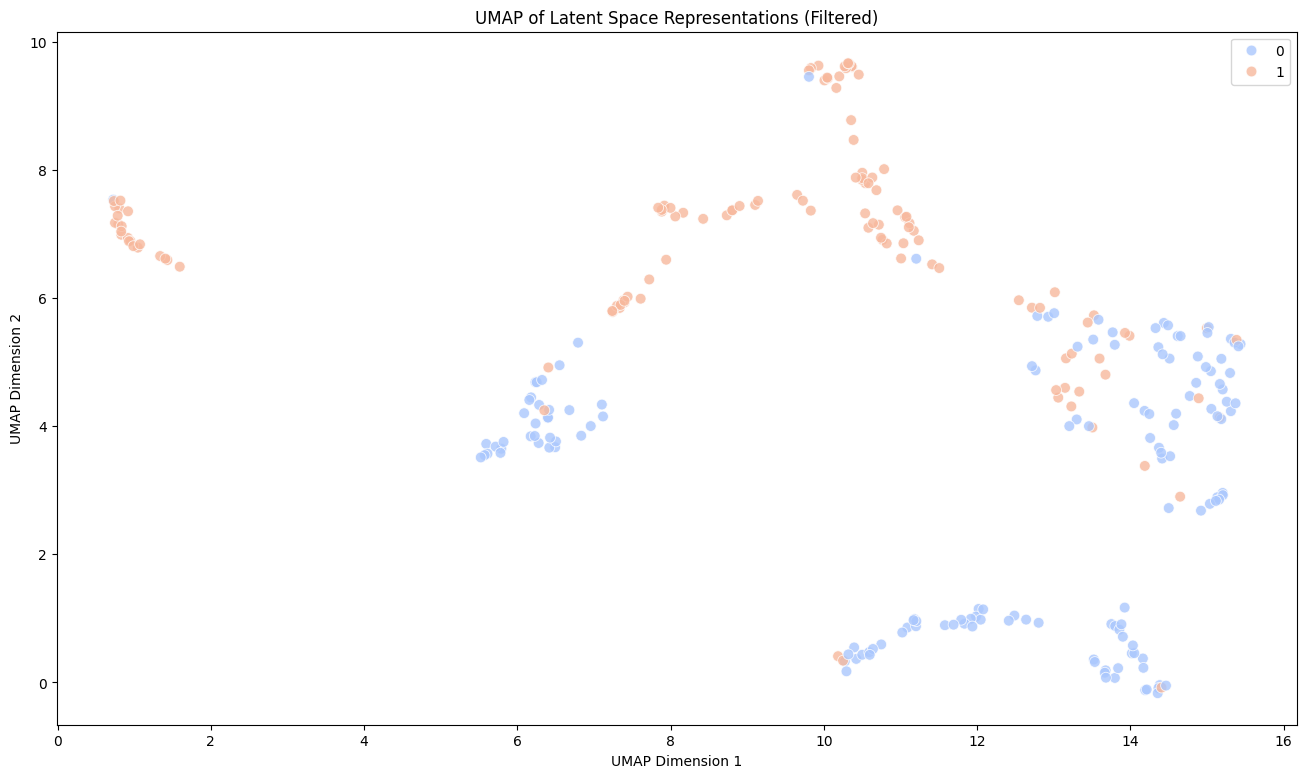


=== Isomap Visualization ===


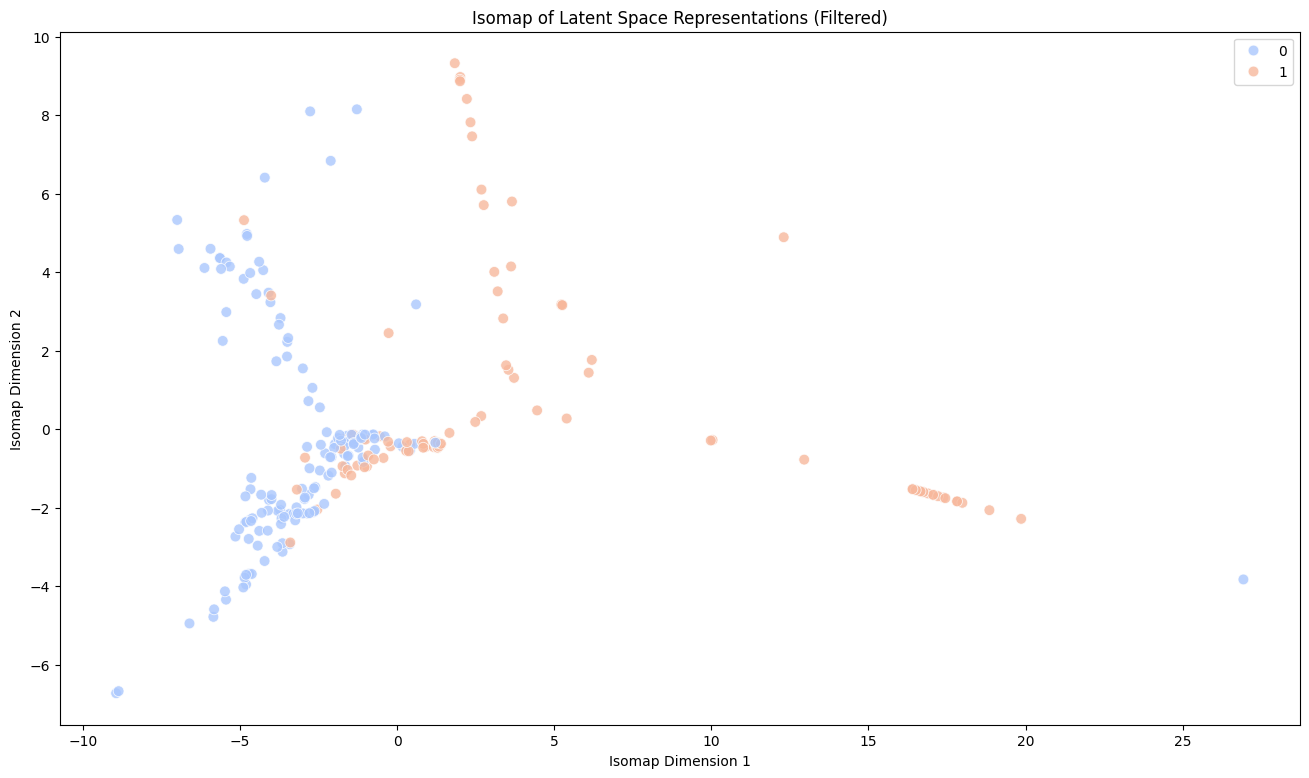

In [ ]:
# Step 1: Extract latent representations
train_latent, train_labels_np = get_latent_representations(filtered_model_1, train_loader_filtered, device)
val_latent, val_labels_np = get_latent_representations(filtered_model_1, val_loader_filtered, device)

# Step 2: Visualize the latent space using PCA
print("\n=== PCA Visualization ===")
visualize_latent_space_pca(val_latent, val_labels_np, filtered_model_1, device, title='PCA of Latent Space Representations (Filtered)')

# Step 3: Perform clustering analysis
print("\n=== Clustering Analysis in Latent Space ===")
cluster_and_visualize(val_latent, val_labels_np, title='Clusters in PCA-Transformed Latent Space (Filtered)')

# Step 4: Visualize the latent space using t-SNE
print("\n=== t-SNE Visualization ===")
visualize_latent_space_tsne(val_latent, val_labels_np, title='t-SNE of Latent Space Representations (Filtered)', palette='coolwarm')

# Step 5: Visualize the latent space using UMAP
print("\n=== UMAP Visualization ===")
visualize_latent_space_umap(val_latent, val_labels_np, title='UMAP of Latent Space Representations (Filtered)', palette='coolwarm')

# Step 6: Visualize the latent space using Isomap
print("\n=== Isomap Visualization ===")
visualize_latent_space_isomap(val_latent, val_labels_np, title='Isomap of Latent Space Representations (Filtered)')


In [ ]:
# Step 1: Remove all repeaters from the dataset
non_repeater_indices = frb_data[frb_data['Repeater'] == 0].index
no_repeater_data_clean = frb_data_clean.loc[non_repeater_indices]
no_repeater_labels = labels.loc[non_repeater_indices]

# Step 2: Standardize the no_repeater dataset
scaler = StandardScaler()
no_repeater_data_scaled = scaler.fit_transform(no_repeater_data_clean)

# Step 3: Split the no_repeater dataset into train and validation sets
train_data_no_repeater, val_data_no_repeater, train_labels_no_repeater, val_labels_no_repeater = train_test_split(
    no_repeater_data_scaled, no_repeater_labels, test_size=0.2, random_state=42, stratify=no_repeater_labels
)

# Step 4: Convert to PyTorch tensors
train_tensor_no_repeater = torch.tensor(train_data_no_repeater, dtype=torch.float32)
val_tensor_no_repeater = torch.tensor(val_data_no_repeater, dtype=torch.float32)
train_labels_tensor_no_repeater = torch.tensor(train_labels_no_repeater.values, dtype=torch.long)
val_labels_tensor_no_repeater = torch.tensor(val_labels_no_repeater.values, dtype=torch.long)

# Step 5: Create datasets and dataloaders
batch_size = 64
train_dataset_no_repeater = TensorDataset(train_tensor_no_repeater, train_labels_tensor_no_repeater)
val_dataset_no_repeater = TensorDataset(val_tensor_no_repeater, val_labels_tensor_no_repeater)

train_loader_no_repeater = DataLoader(train_dataset_no_repeater, batch_size=batch_size, shuffle=True)
val_loader_no_repeater = DataLoader(val_dataset_no_repeater, batch_size=batch_size, shuffle=False)

# Step 7: Train the model with the no_repeater dataset
filtered_model_2 = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

filtered_model_2.load_state_dict(torch.load("best_model_no_repeaters.pth", map_location=device))

def evaluate_classifier_full_oneclass(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    # f1 = sklearn.metrics.f1_score(all_labels, all_preds)
    # class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return conf_matrix, all_preds, all_labels

# Evaluate the model after training

conf_mat_no_repeaters, _, _ = evaluate_classifier_full_oneclass(filtered_model_2, val_loader_no_repeater, device)

conf_mat_no_repeaters

/tmp/ipykernel_1895578/1525501124.py:38: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metric

array([[150]])


=== PCA Visualization ===


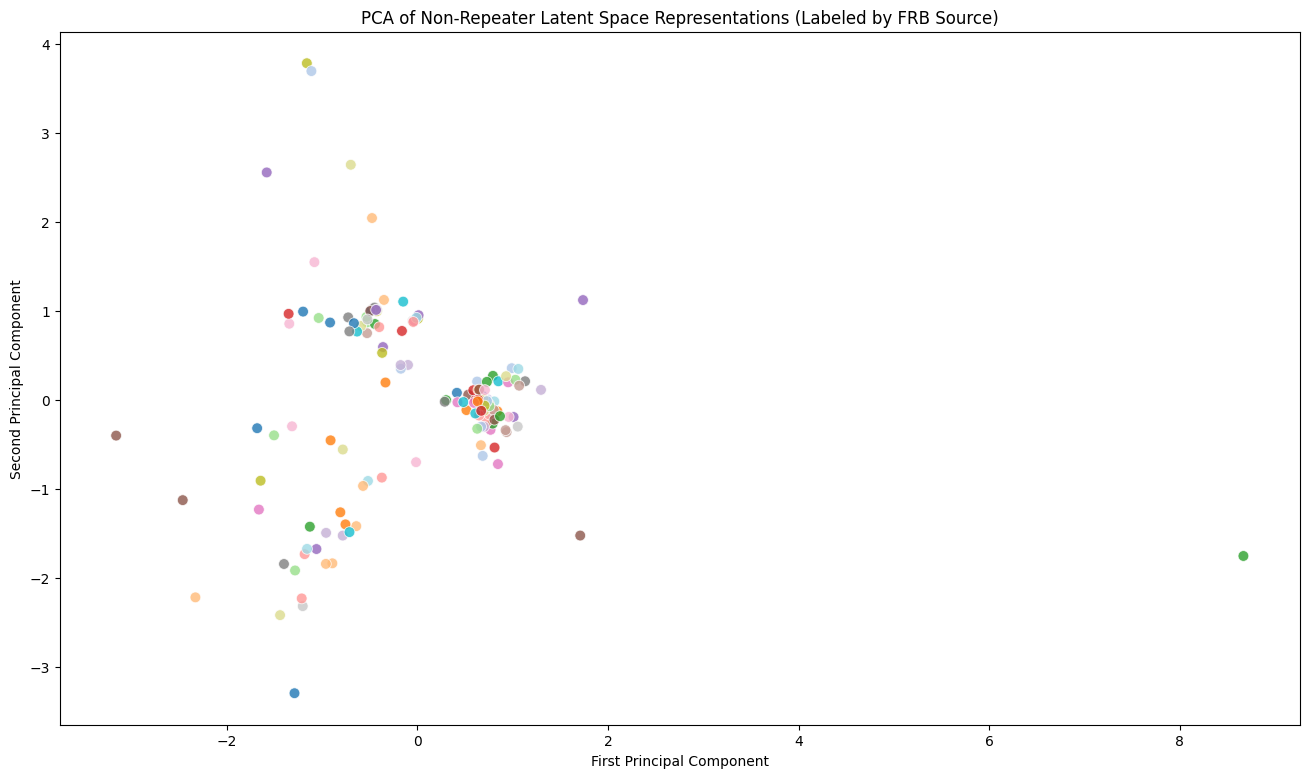


=== t-SNE Visualization ===


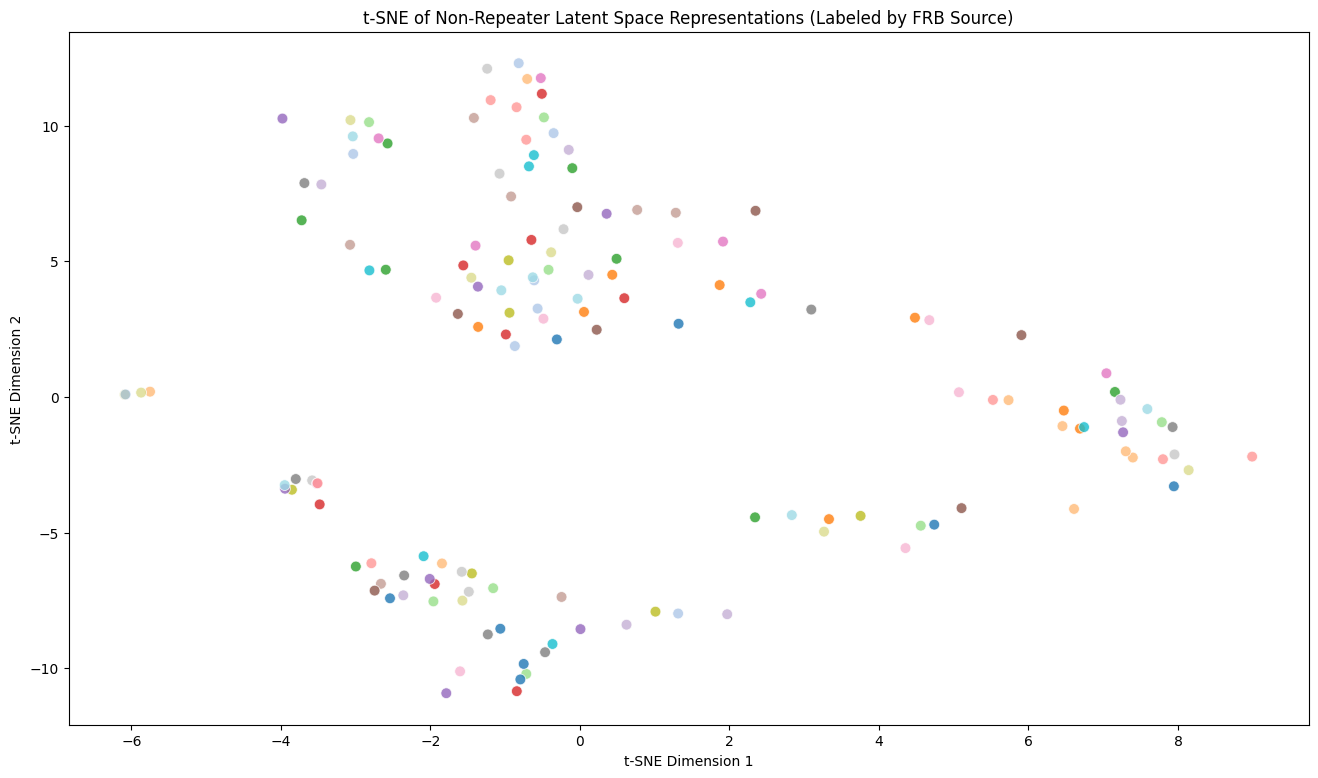


=== UMAP Visualization ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



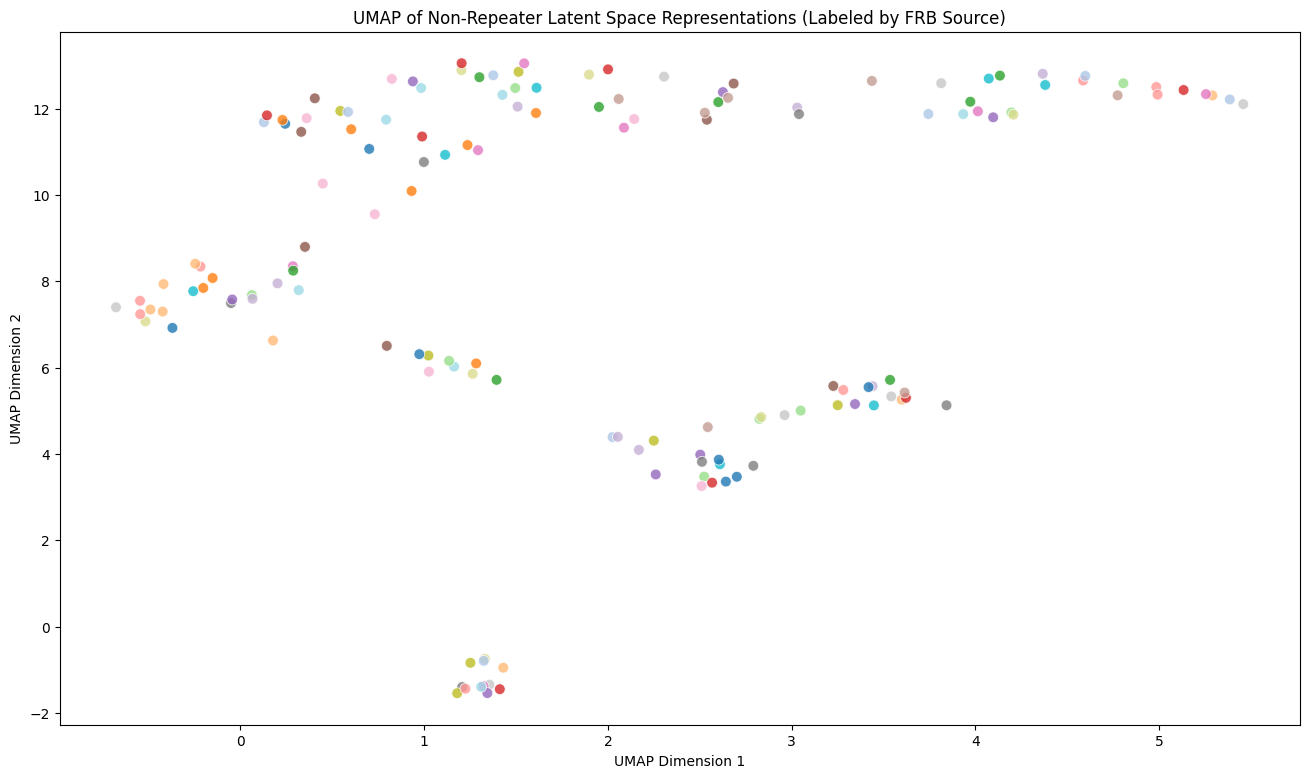

In [ ]:
# Step 1: Extract latent representations
train_latent, train_labels_np = get_latent_representations(filtered_model_2, train_loader_no_repeater, device)
val_latent, val_labels_np = get_latent_representations(filtered_model_2, val_loader_no_repeater, device)


def visualize_latent_space_pca_source_nolegend(latent_representations, sources):
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=sources, palette="tab20", s=60, alpha=0.8, legend=False)
    plt.title('PCA of Non-Repeater Latent Space Representations (Labeled by FRB Source)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.savefig('PCA of Latent Space Representations (Labeled by FRB Source).png'.replace(" ", "_"), dpi=500) 
    plt.show()
    
def visualize_latent_space_tsne_nolegend(latent_representations, sources):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_representations)

    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=sources, palette="tab20", s=60, alpha=0.8, legend=False)
    plt.title('t-SNE of Non-Repeater Latent Space Representations (Labeled by FRB Source)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.savefig('t-SNE of Latent Space Representations (Labeled by FRB Source).png'.replace(" ", "_"), dpi=500)
    plt.show()
    
def visualize_latent_space_umap_source_nolegend(latent_representations, sources):
    reducer = umap.UMAP(n_components=2, random_state=42)
    latent_2d = reducer.fit_transform(latent_representations)

    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=sources, palette="tab20", s=60, alpha=0.8, legend=False)
    plt.title('UMAP of Non-Repeater Latent Space Representations (Labeled by FRB Source)')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.savefig('UMAP of Latent Space Representations (Labeled by FRB Source).png'.replace(" ", "_"), dpi=500)
    plt.show()




# Extract the source names for the validation set
val_sources_no_repeater = original_data.loc[val_labels_no_repeater.index, "Source"].values


# Step 2: Visualize the latent space using PCA
print("\n=== PCA Visualization ===")
visualize_latent_space_pca_source_nolegend(val_latent, val_sources_no_repeater)

# Step 4: Visualize the latent space using t-SNE
print("\n=== t-SNE Visualization ===")
visualize_latent_space_tsne_nolegend(val_latent, val_sources_no_repeater)

# Step 5: Visualize the latent space using UMAP
print("\n=== UMAP Visualization ===")
visualize_latent_space_umap_source_nolegend(val_latent, val_sources_no_repeater)



=== Final Evaluation ===
Validation Accuracy: 0.8821
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.91      0.88      0.89       150
    Repeater       0.87      0.90      0.88       129

    accuracy                           0.89       279
   macro avg       0.89      0.89      0.89       279
weighted avg       0.89      0.89      0.89       279

Confusion Matrix:
 [[132  18]
 [ 13 116]]

=== PCA Visualization ===


/tmp/ipykernel_1895578/31173372.py:67: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



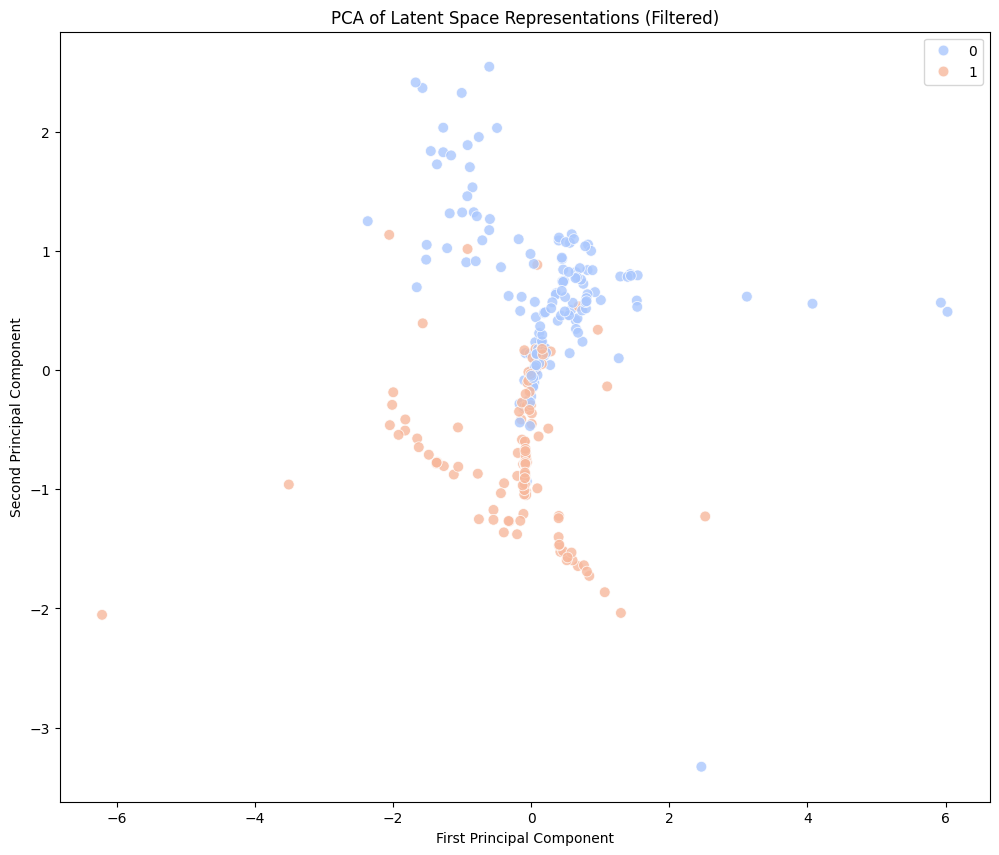


=== Clustering Analysis in Latent Space ===


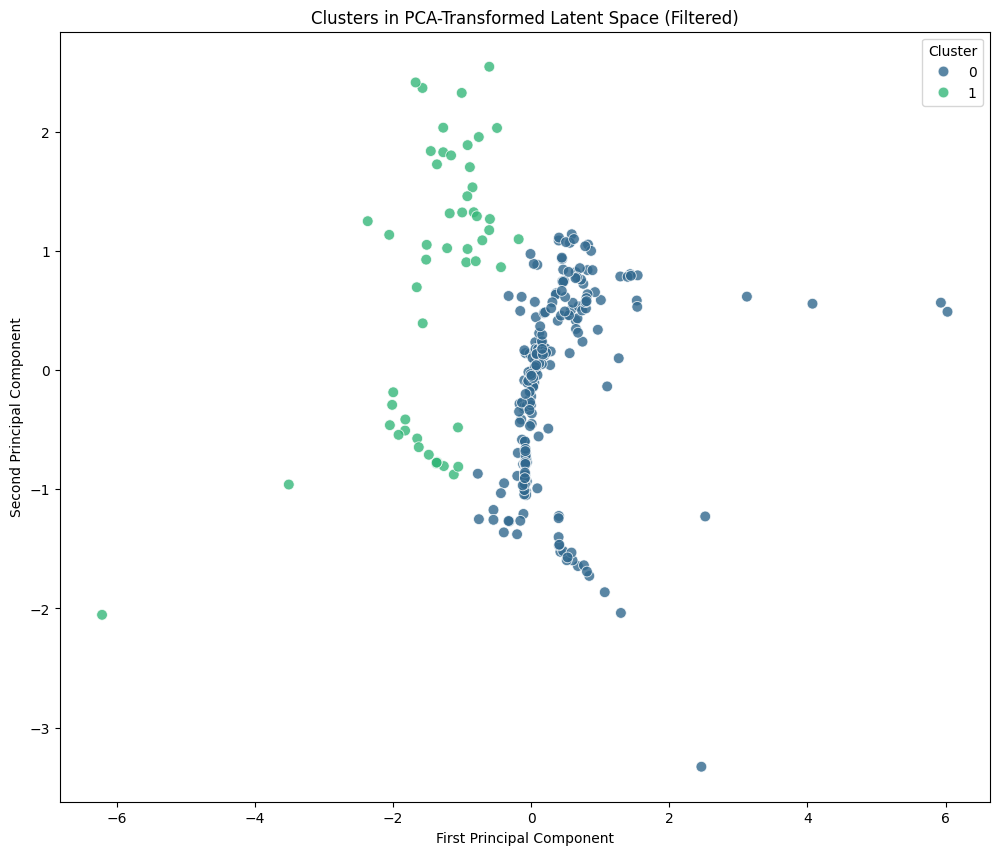

Silhouette Score: 0.4550666809082031
Adjusted Rand Index (ARI): -0.0040578762344514515

=== t-SNE Visualization ===


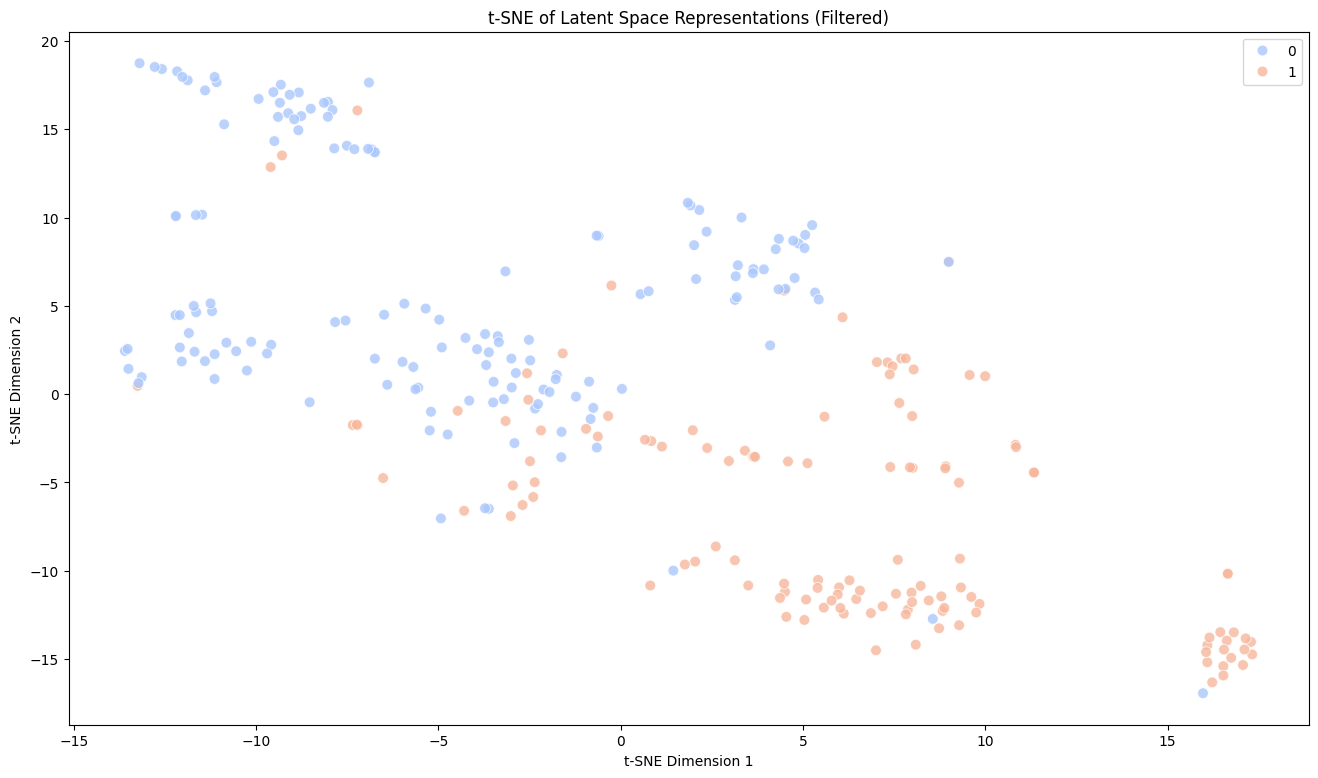


=== UMAP Visualization ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



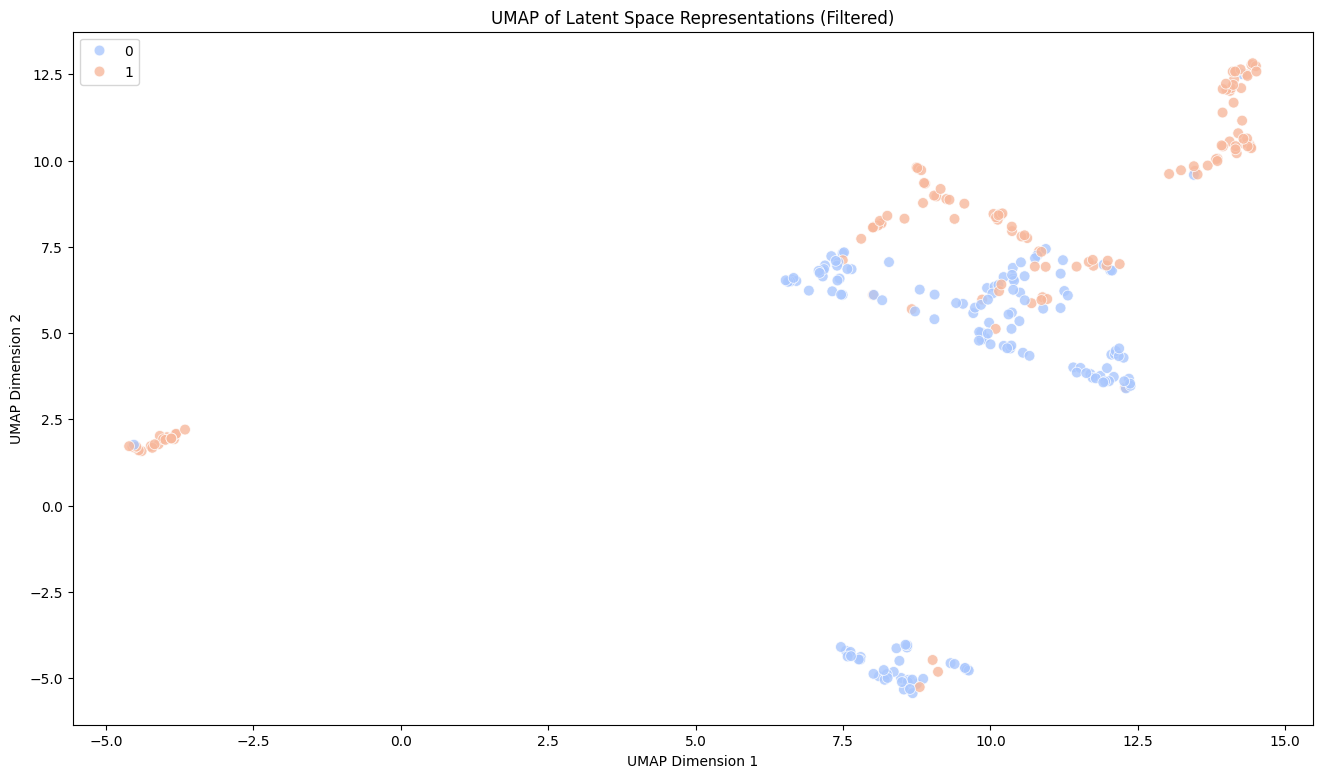


=== Isomap Visualization ===


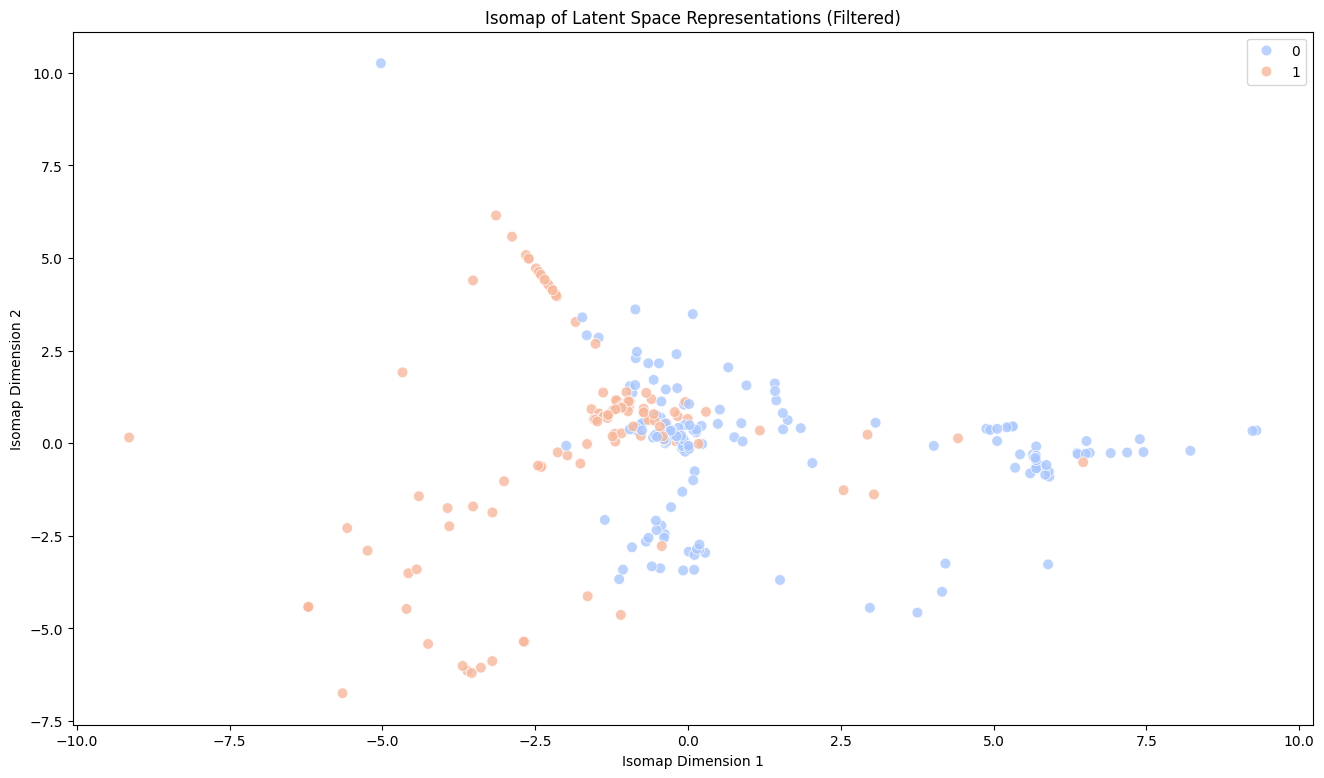

In [ ]:
#import DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Step 1: Identify the 5 most frequent repeaters
repeater_counts = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts()
top_5_repeaters = repeater_counts.head(5).index.tolist()

# # Step 2: Filter the dataset to exclude these repeaters
# filtered_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index
# filtered_data_clean = frb_data_clean.loc[filtered_indices]
# filtered_labels = labels.loc[filtered_indices]

top_5_repeaters = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts().head(5).index.tolist()

# Sample 10 signals from each top repeater
sampled_indices = []
for repeater in top_5_repeaters:
    repeater_indices = frb_data[frb_data['Source'] == repeater].index
    sampled = np.random.choice(repeater_indices, size=min(5, len(repeater_indices)), replace=False)
    sampled_indices.extend(sampled)

# Get all other indices excluding the top 5 repeaters
non_top5_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index

# Combine the sampled top5 and the rest
final_indices = np.concatenate([non_top5_indices, sampled_indices])

# Filter the clean data and labels accordingly
filtered_data_clean = frb_data_clean.loc[final_indices]
filtered_labels = labels.loc[final_indices]


# Step 3: Standardize the filtered dataset
scaler = StandardScaler()
filtered_data_scaled = scaler.fit_transform(filtered_data_clean)

# Step 4: Split the filtered dataset into train and validation sets
train_data_filtered, val_data_filtered, train_labels_filtered, val_labels_filtered = train_test_split(
    filtered_data_scaled, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
)

# Step 5: Convert to PyTorch tensors
train_tensor_filtered = torch.tensor(train_data_filtered, dtype=torch.float32)
val_tensor_filtered = torch.tensor(val_data_filtered, dtype=torch.float32)
train_labels_tensor_filtered = torch.tensor(train_labels_filtered.values, dtype=torch.long)
val_labels_tensor_filtered = torch.tensor(val_labels_filtered.values, dtype=torch.long)

# Step 6: Create datasets and dataloaders
batch_size = 64
train_dataset_filtered = TensorDataset(train_tensor_filtered, train_labels_tensor_filtered)
val_dataset_filtered = TensorDataset(val_tensor_filtered, val_labels_tensor_filtered)

train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=batch_size, shuffle=True)
val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=batch_size, shuffle=False)


# Step 7: Train the model with the filtered dataset
filtered_model_3 = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

filtered_model_3.load_state_dict(torch.load("filtered_model_sampled.pth", map_location=device))


# Evaluate the model after training
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(filtered_model_3, val_loader_filtered, device)

print("\n=== Final Evaluation ===")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)
# Step 1: Extract latent representations
train_latent, train_labels_np = get_latent_representations(filtered_model_3, train_loader_filtered, device)
val_latent, val_labels_np = get_latent_representations(filtered_model_3, val_loader_filtered, device)

# Step 2: Visualize the latent space using PCA
print("\n=== PCA Visualization ===")
visualize_latent_space_pca(val_latent, val_labels_np, filtered_model_3, device, title='PCA of Latent Space Representations (Filtered)')

# Step 3: Perform clustering analysis
print("\n=== Clustering Analysis in Latent Space ===")
cluster_and_visualize(val_latent, val_labels_np, title='Clusters in PCA-Transformed Latent Space (Filtered)')

# Step 4: Visualize the latent space using t-SNE
print("\n=== t-SNE Visualization ===")
visualize_latent_space_tsne(val_latent, val_labels_np, title='t-SNE of Latent Space Representations (Filtered)', palette='coolwarm')

# Step 5: Visualize the latent space using UMAP
print("\n=== UMAP Visualization ===")
visualize_latent_space_umap(val_latent, val_labels_np, title='UMAP of Latent Space Representations (Filtered)', palette='coolwarm')

# Step 6: Visualize the latent space using Isomap
print("\n=== Isomap Visualization ===")
visualize_latent_space_isomap(val_latent, val_labels_np, title='Isomap of Latent Space Representations (Filtered)')

FRB20190112A is similar to FRB20191106C with a score of 1.07711 (Repeater difference)
FRB20190112A is similar to FRB20190915D with a score of 0.85791 (Repeater difference)


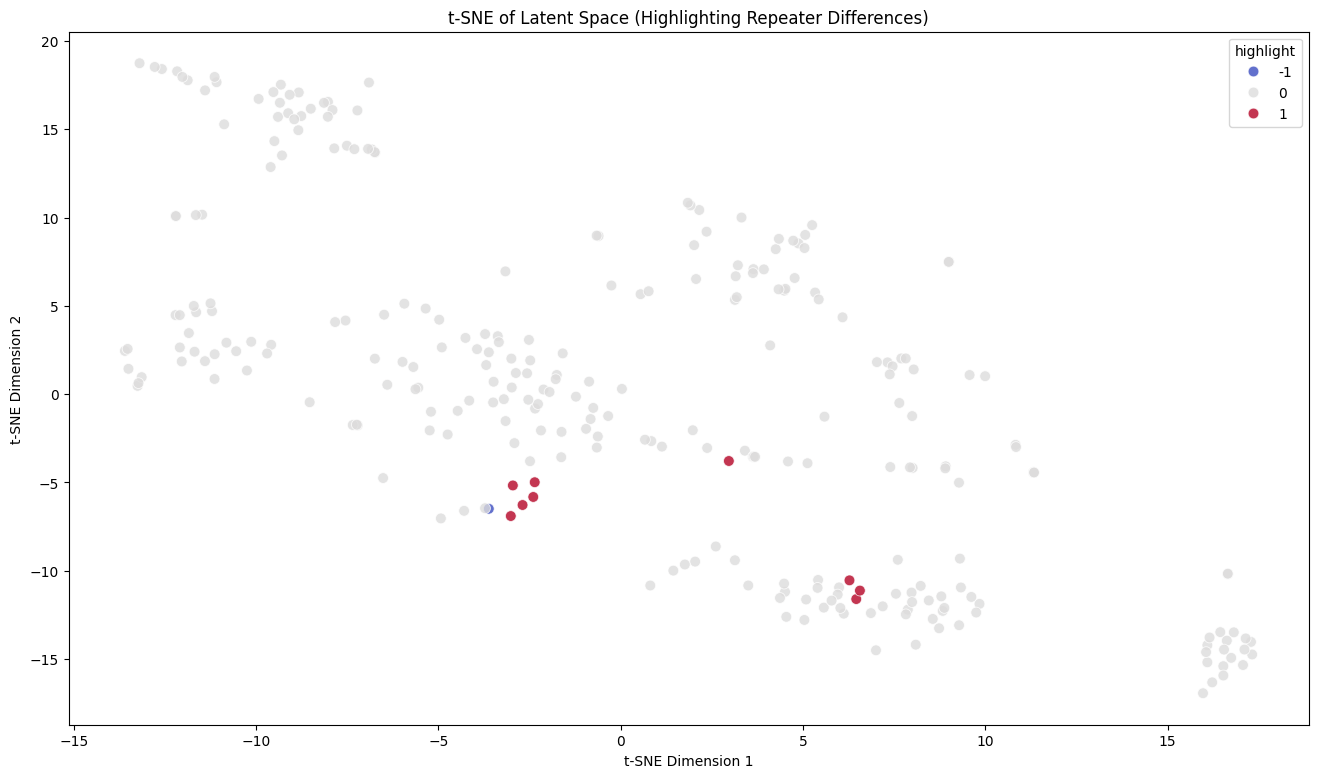

In [ ]:
val_index = val_labels_filtered.index
val_sources = original_data.loc[val_index, 'Source'].values

latent_df = pd.DataFrame(val_latent, index=val_index)
latent_df['Source'] = val_sources

# Fit Nearest Neighbors
nbrs = NearestNeighbors(n_neighbors=6).fit(val_latent)
distances, indices = nbrs.kneighbors(val_latent)

# Simple nearest neighbor lookup (no cluster checks)
def find_similar(source):
    idx = latent_df[latent_df['Source'] == source].index[0]
    pos = list(latent_df.index).index(idx)

    neighbors = {}
    for i, neighbor_pos in enumerate(indices[pos][1:]):  # skip self (first neighbor)
        neighbor_idx = latent_df.index[neighbor_pos]
        neighbors[latent_df.loc[neighbor_idx, 'Source']] = float(distances[pos][i+1])
    return neighbors

# Track pairs where a non-repeater is similar to a repeater
highlight_non_repeaters = set()
highlight_repeaters = set()

for source in all_false_positives:
    if source in garcia_list and source in zhu_ge_list and source in luo_list and source in latent_df['Source'].values:
        similar_source_data = find_similar(source)
        if similar_source_data:
            for similar_source, score in similar_source_data.items():
                source_repeater = frb_data[frb_data['Source'] == source]['Repeater'].values[0]
                neighbor_repeater = frb_data[frb_data['Source'] == similar_source]['Repeater'].values[0]

                if source_repeater != neighbor_repeater:
                    print(f"{source} is similar to {similar_source} with a score of {score:.5f} (Repeater difference)")
                    if source_repeater == 0:
                        highlight_non_repeaters.add(source)
                        highlight_repeaters.add(similar_source)
                    else:
                        highlight_non_repeaters.add(similar_source)
                        highlight_repeaters.add(source)

# Now create a color array for visualization
# 0 = normal, 1 = non-repeater flagged, 2 = repeater flagged
colors = []
for source in latent_df['Source']:
    if source in highlight_non_repeaters:
        colors.append(-1)
    elif source in highlight_repeaters:
        colors.append(1)
    else:
        colors.append(0)

latent_df['highlight'] = colors

# Updated visualization call
visualize_latent_space_tsne(val_latent, latent_df['highlight'], title='t-SNE of Latent Space (Highlighting Repeater Differences)', palette='coolwarm')

In [ ]:
import numpy as np

def calculate_classification_metrics(confusion_matrix):
    """
    Calculate classification metrics from a confusion matrix.
    
    Args:
        confusion_matrix (np.array): 2x2 array in format [[TN, FP], [FN, TP]]
    
    Returns:
        dict: Dictionary containing accuracy, precision, recall, F1 score
    """
    TN, FP, FN, TP = confusion_matrix.ravel()

    # Metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) else 0.0
    recall = TP / (TP + FN) if (TP + FN) else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0.0

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

# Example: Signal-level confusion matrix
conf_mat_signals = np.array([
    [719, 29],
    [21, 7895]
])

# Example: Source-level confusion matrix
conf_mat_sources = np.array([
    [719, 29],
    [17, 67]
])

# Calculate metrics
metrics_signals = calculate_classification_metrics(conf_mat_dups)
metrics_sources = calculate_classification_metrics(conf_mat_final)

# Print results
print("=== Signal-Level Metrics ===")
for k, v in metrics_signals.items():
    print(f"{k}: {v:.4f}")

print("\n=== Source-Level Metrics ===")
for k, v in metrics_sources.items():
    print(f"{k}: {v:.4f}")


=== Signal-Level Metrics ===
Accuracy: 0.9942
Precision: 0.9963
Recall: 0.9973
F1 Score: 0.9968

=== Source-Level Metrics ===
Accuracy: 0.9447
Precision: 0.6979
Recall: 0.7976
F1 Score: 0.7444
